# Graph-Based Anomaly Detection: From Theory to Practice

Welcome to this comprehensive exploration of anomaly detection in graph-structured data. In this notebook, we'll journey from fundamental graph concepts to advanced deep learning techniques for identifying anomalous nodes, edges, and subgraphs.

## What You'll Learn
- Essential graph theory concepts and representations
- Statistical approaches to graph anomaly detection
- Graph embedding techniques (DeepWalk, Node2Vec)
- Graph Neural Networks (GNNs) architecture and applications
- Graph Convolutional Networks (GCNs) for anomaly detection
- Advanced GCN autoencoder models for unsupervised anomaly detection

By the end, you'll understand both the theoretical foundations and practical implementations of these methods using popular libraries like NetworkX, node2vec, and PyTorch Geometric.


In [ ]:
# Install necessary libraries
!pip install networkx matplotlib pandas scikit-learn node2vec torch

# Install specific compatible versions of numpy and scipy
# These versions satisfy node2vec and gensim requirements (<2.0 for numpy, <1.14.0 for scipy)
# and are generally compatible with other common libraries.
!pip install numpy==1.24.4 scipy==1.10.1

# Install torch-scatter and torch-sparse with specific CUDA version if needed, or cpu-only
# For CPU only:
#!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
# For CUDA 11.8:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric


# Import common libraries we'll use throughout the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import random
import warnings

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.8/891.8 kB 20.8 MB/s eta 0:00:00


## 1. Graph Fundamentals

### 1.1 What is a Graph?

A graph is a mathematical structure consisting of:
- **Nodes** (also called vertices): Representing entities
- **Edges**: Representing relationships between entities

Graphs are powerful data structures because they explicitly model relationships rather than treating data points as independent.

### 1.2 Types of Graphs

- **Undirected Graph**: Edges have no direction (friendship network)
- **Directed Graph**: Edges have direction (follower relationships)
- **Weighted Graph**: Edges have weights (distances, strengths)
- **Attributed Graph**: Nodes and edges have features (user profiles, transaction details)
- **Dynamic Graph**: Graph structure evolves over time (communication networks)


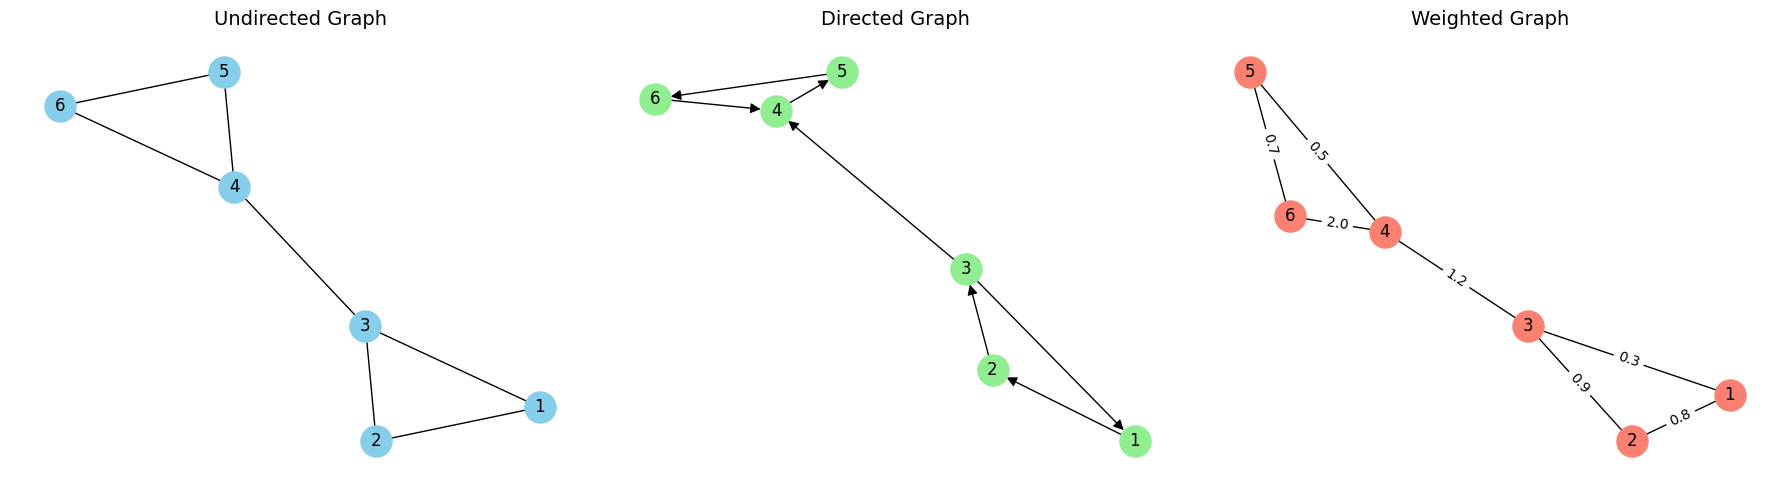

In [ ]:
# Let's create and visualize different types of graphs

# Create plots for different graph types
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Undirected graph
G_undirected = nx.Graph()
G_undirected.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])

pos_undirected = nx.spring_layout(G_undirected, seed=42)
nx.draw(G_undirected, pos_undirected, with_labels=True, node_color='skyblue',
        node_size=500, ax=axes[0])
axes[0].set_title('Undirected Graph', fontsize=14)

# 2. Directed graph
G_directed = nx.DiGraph()
G_directed.add_edges_from([(1, 2), (2, 3), (3, 1), (3, 4), (4, 5), (5, 6), (6, 4)])

pos_directed = nx.spring_layout(G_directed, seed=42)
nx.draw(G_directed, pos_directed, with_labels=True, node_color='lightgreen',
        node_size=500, ax=axes[1], arrows=True, arrowsize=15)
axes[1].set_title('Directed Graph', fontsize=14)

# 3. Weighted graph
G_weighted = nx.Graph()
weighted_edges = [(1, 2, 0.8), (1, 3, 0.3), (2, 3, 0.9),
                  (3, 4, 1.2), (4, 5, 0.5), (5, 6, 0.7), (4, 6, 2.0)]
G_weighted.add_weighted_edges_from(weighted_edges)

pos_weighted = nx.spring_layout(G_weighted, seed=42)
nx.draw(G_weighted, pos_weighted, with_labels=True, node_color='salmon',
        node_size=500, ax=axes[2])

# Add edge labels for weights
edge_labels = nx.get_edge_attributes(G_weighted, 'weight')
nx.draw_networkx_edge_labels(G_weighted, pos_weighted, edge_labels=edge_labels, ax=axes[2])
axes[2].set_title('Weighted Graph', fontsize=14)

plt.tight_layout()
plt.show()


### 1.3 Graph Representations

Graphs can be represented in several ways:

1. **Adjacency Matrix**: An n×n matrix where n is the number of nodes. Entry A[i,j] = 1 if there's an edge from node i to node j, otherwise 0.
   - Pros: Simple for dense graphs, efficient for operations like matrix multiplication
   - Cons: Memory inefficient for sparse graphs

2. **Adjacency List**: For each node, store a list of its neighboring nodes.
   - Pros: Memory efficient for sparse graphs
   - Cons: Less efficient for checking if two nodes are connected

3. **Edge List**: Simply a list of edges (i,j).
   - Pros: Most compact representation
   - Cons: Inefficient for many operations


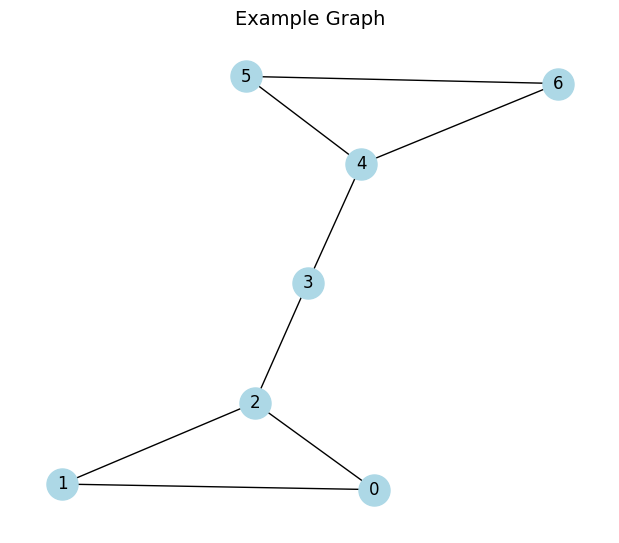

1. Adjacency Matrix:
[[0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 0 1 0 1 1]
 [0 0 0 0 1 0 1]
 [0 0 0 0 1 1 0]]

2. Adjacency List:
Node 0: [1, 2]
Node 1: [0, 2]
Node 2: [0, 1, 3]
Node 3: [2, 4]
Node 4: [3, 5, 6]
Node 5: [4, 6]
Node 6: [4, 5]

3. Edge List:
[(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)]


In [ ]:
# Let's create visual representations of these formats for the same graph

# Create a simple graph
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])

# Visualize the graph
plt.figure(figsize=(6, 5))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.title('Example Graph', fontsize=14)
plt.show()

# Display the different representations
print("1. Adjacency Matrix:")
A = nx.adjacency_matrix(G).todense()
print(A)
print("\n2. Adjacency List:")
for node in G.nodes():
    print(f"Node {node}: {list(G.neighbors(node))}")
print("\n3. Edge List:")
print(list(G.edges()))

# For later use, we'll need functions to convert between formats
def adj_matrix_to_edge_list(A):
    """Convert adjacency matrix to edge list"""
    edge_list = []
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                edge_list.append((i, j, A[i, j]))
    return edge_list

def edge_list_to_adj_matrix(edge_list, n_nodes):
    """Convert edge list to adjacency matrix"""
    A = np.zeros((n_nodes, n_nodes))
    for edge in edge_list:
        i, j, w = edge
        A[i, j] = w
        if not nx.is_directed(G):  # If undirected, make symmetric
            A[j, i] = w
    return A


### 1.4 Graph Measures and Properties

To detect anomalies in graphs, we need to understand what "normal" looks like. Here are some key measures:

#### Node-level Metrics:
- **Degree**: Number of connections a node has
- **Clustering coefficient**: How connected a node's neighbors are to each other
- **Centrality measures**:
  - Betweenness: How often a node lies on shortest paths between other nodes
  - Closeness: Average shortest path distance to all other nodes
  - Eigenvector: Node importance based on importance of its connections

#### Graph-level Metrics:
- **Density**: Ratio of actual edges to possible edges
- **Diameter**: Length of the longest shortest path
- **Average path length**: Average shortest path between all pairs of nodes
- **Community structure**: Groups of nodes densely connected internally


Node-level Metrics (first 5 nodes):
   Degree  Clustering  Betweenness  Closeness  Eigenvector
0      10    0.311111     0.128732   0.678571     0.386950
1       4    0.333333     0.012541   0.542857     0.180779
2       3    0.666667     0.001170   0.487179     0.163433
3       6    0.200000     0.064133   0.575758     0.206455
4       9    0.194444     0.135912   0.655172     0.322358

Graph-level Metrics:
Density: 0.2684
Diameter: 3
Average path length: 1.8316
Average clustering coefficient: 0.3359


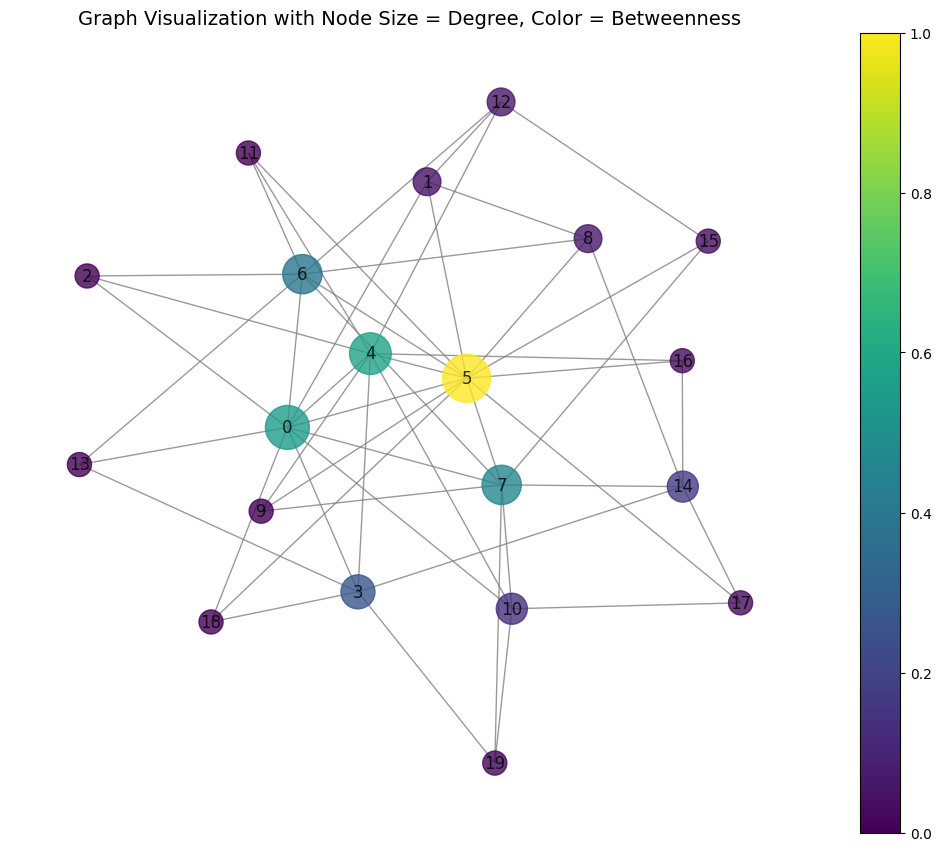

In [ ]:
# Let's calculate these metrics for our graph

# Create a larger graph to demonstrate metrics
G_metrics = nx.barabasi_albert_graph(20, 3, seed=42)  # Scale-free graph

# Calculate node-level metrics
degrees = dict(G_metrics.degree())
clustering = nx.clustering(G_metrics)
betweenness = nx.betweenness_centrality(G_metrics)
closeness = nx.closeness_centrality(G_metrics)
eigenvector = nx.eigenvector_centrality(G_metrics)

# Combine into a DataFrame for easier viewing
metrics_df = pd.DataFrame({
    'Degree': pd.Series(degrees),
    'Clustering': pd.Series(clustering),
    'Betweenness': pd.Series(betweenness),
    'Closeness': pd.Series(closeness),
    'Eigenvector': pd.Series(eigenvector)
})

# Calculate graph-level metrics
density = nx.density(G_metrics)
try:
    diameter = nx.diameter(G_metrics)
except:
    diameter = "Graph is not connected"
avg_path = nx.average_shortest_path_length(G_metrics)
avg_clustering = nx.average_clustering(G_metrics)

# Show results
print("Node-level Metrics (first 5 nodes):")
print(metrics_df.head(5))

print("\nGraph-level Metrics:")
print(f"Density: {density:.4f}")
print(f"Diameter: {diameter}")
print(f"Average path length: {avg_path:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")

# Visualize the graph with node size proportional to degree
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_metrics, seed=42)
node_size = [v * 100 for v in degrees.values()]
node_color = list(betweenness.values())
nx.draw(G_metrics, pos, with_labels=True,
        node_size=node_size, node_color=node_color,
        cmap='viridis', edge_color='gray', alpha=0.8)
plt.title('Graph Visualization with Node Size = Degree, Color = Betweenness', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca())
plt.show()


## 2. Creating a Graph Dataset for Anomaly Detection

Let's create a synthetic graph dataset that models a financial transaction network with some fraudulent patterns injected. This will serve as our example throughout the notebook.

In financial transaction networks:
- Nodes represent accounts or entities
- Edges represent transactions between accounts
- Edge weights might represent transaction amounts
- Node features might include account information


Created graph with 109 nodes and 501 edges
Injected 10 anomalous nodes and 31 anomalous edges


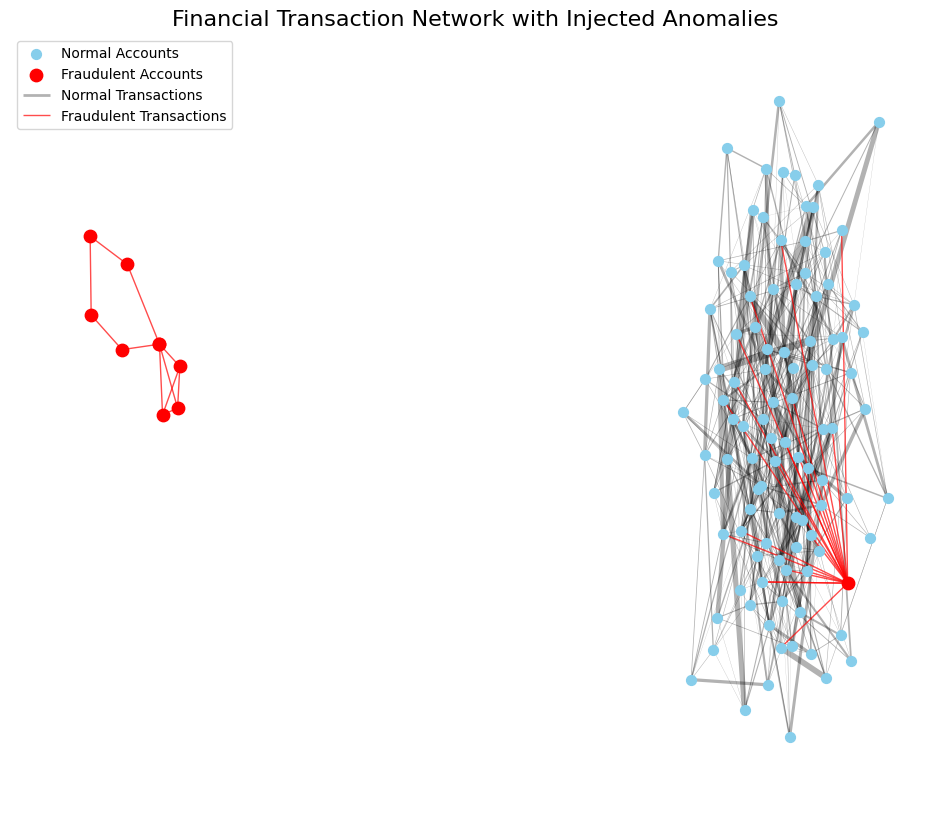

In [ ]:
# Create a financial transaction network with injected anomalies
def create_transaction_network(n_accounts=100, n_transactions=500, n_features=8,
                              n_fraudsters=5, anomaly_types=['structural', 'attribute', 'combined']):
    """
    Create a synthetic financial transaction network with injected anomalies.

    Parameters:
    -----------
    n_accounts : int
        Number of accounts (nodes) in the network
    n_transactions : int
        Number of normal transactions (edges)
    n_features : int
        Number of features per account
    n_fraudsters : int
        Number of fraudulent accounts to inject
    anomaly_types : list
        Types of anomalies to inject

    Returns:
    --------
    G : networkx.Graph
        Transaction network with anomalies
    anomaly_nodes : list
        List of anomalous node indices
    anomaly_edges : list
        List of anomalous edge tuples
    """
    # Create an empty graph
    G = nx.Graph()

    # Add normal accounts with features
    for i in range(n_accounts):
        # Generate normal account features (e.g., avg balance, account age, etc.)
        features = np.random.normal(0, 1, n_features)
        G.add_node(i, features=features, anomaly=False, anomaly_type=None)

    # Add normal transactions
    for _ in range(n_transactions):
        source = np.random.randint(0, n_accounts)
        target = np.random.randint(0, n_accounts)
        if source != target:  # Avoid self-loops
            amount = np.random.lognormal(mean=3, sigma=1)  # Transaction amount
            G.add_edge(source, target, weight=amount, anomaly=False)

    # Inject anomalies
    anomaly_nodes = []
    anomaly_edges = []

    # 1. Structural anomalies: Unusual connectivity patterns
    if 'structural' in anomaly_types:
        # Create a fraudster with unusually high out-degree (many small transactions)
        fraudster = n_accounts
        G.add_node(fraudster, features=np.random.normal(0, 1, n_features),
                  anomaly=True, anomaly_type='structural')
        for _ in range(20):  # Many outgoing transactions
            target = np.random.randint(0, n_accounts)
            amount = np.random.lognormal(mean=1, sigma=0.2)  # Small amounts
            G.add_edge(fraudster, target, weight=amount, anomaly=True)
            anomaly_edges.append((fraudster, target))
        anomaly_nodes.append(fraudster)
        n_accounts += 1

        # Create a circular transaction pattern (money laundering)
        start_idx = n_accounts
        circle_size = 5
        for i in range(circle_size):
            node_idx = start_idx + i
            G.add_node(node_idx, features=np.random.normal(0, 1, n_features),
                      anomaly=True, anomaly_type='structural')
            anomaly_nodes.append(node_idx)

        # Add circular edges
        for i in range(circle_size):
            source = start_idx + i
            target = start_idx + (i + 1) % circle_size
            G.add_edge(source, target, weight=np.random.lognormal(mean=4, sigma=0.1),
                      anomaly=True)
            anomaly_edges.append((source, target))

        n_accounts += circle_size

    # 2. Attribute anomalies: Unusual feature values
    if 'attribute' in anomaly_types:
        # Create accounts with unusual feature values
        for i in range(n_fraudsters - len(anomaly_nodes)):
            node_idx = n_accounts + i
            # Very unusual feature values (large deviation)
            features = np.random.normal(5, 2, n_features)
            G.add_node(node_idx, features=features, anomaly=True,
                      anomaly_type='attribute')

            # Add some normal-looking transactions
            for _ in range(np.random.randint(2, 6)):
                target = np.random.randint(0, n_accounts)
                amount = np.random.lognormal(mean=3, sigma=1)
                G.add_edge(node_idx, target, weight=amount, anomaly=False)

            anomaly_nodes.append(node_idx)

        n_accounts += n_fraudsters - len(anomaly_nodes)

    # 3. Combined anomalies: Both structural and attribute irregularities
    if 'combined' in anomaly_types:
        # Create a densely connected group with unusual features
        group_size = 4
        start_idx = n_accounts

        # Create nodes with unusual features
        for i in range(group_size):
            node_idx = start_idx + i
            features = np.random.normal(3, 1, n_features)
            # Last feature is highly anomalous
            features[-1] = np.random.uniform(8, 10)
            G.add_node(node_idx, features=features, anomaly=True,
                      anomaly_type='combined')
            anomaly_nodes.append(node_idx)

        # Create dense connections within group
        for i in range(group_size):
            for j in range(i+1, group_size):
                source = start_idx + i
                target = start_idx + j
                G.add_edge(source, target, weight=np.random.lognormal(mean=5, sigma=0.5),
                          anomaly=True)
                anomaly_edges.append((source, target))

        n_accounts += group_size

    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Injected {len(anomaly_nodes)} anomalous nodes and {len(anomaly_edges)} anomalous edges")

    return G, anomaly_nodes, anomaly_edges

# Create our transaction network
G_financial, anomaly_nodes, anomaly_edges = create_transaction_network()

# Visualize the network
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_financial, seed=42)

# Draw normal nodes and edges
normal_nodes = [n for n in G_financial.nodes() if n not in anomaly_nodes]
nx.draw_networkx_nodes(G_financial, pos, nodelist=normal_nodes,
                      node_color='skyblue', node_size=50)
nx.draw_networkx_nodes(G_financial, pos, nodelist=anomaly_nodes,
                      node_color='red', node_size=80)

# Draw edges with width proportional to weight
edge_widths = [0.1 + 0.2 * G_financial[u][v]['weight']/10 for u, v in G_financial.edges()]

# Normal edges
normal_edges = [(u, v) for u, v in G_financial.edges() if (u, v) not in anomaly_edges and (v, u) not in anomaly_edges]
nx.draw_networkx_edges(G_financial, pos, edgelist=normal_edges,
                      width=edge_widths[:len(normal_edges)], alpha=0.3)

# Anomalous edges
nx.draw_networkx_edges(G_financial, pos, edgelist=anomaly_edges,
                      edge_color='red', width=1, alpha=0.7)

plt.title('Financial Transaction Network with Injected Anomalies', fontsize=16)
plt.legend(['Normal Accounts', 'Fraudulent Accounts', 'Normal Transactions', 'Fraudulent Transactions'])
plt.axis('off')
plt.show()


## 3. Traditional Graph Anomaly Detection Methods

Traditional methods for graph anomaly detection typically rely on statistical properties of the graph structure. These methods are computationally efficient but may miss complex patterns.

We'll explore approaches based on:
1. **Node metrics**: Finding nodes with unusual statistics
2. **Community detection**: Identifying nodes that don't fit well in communities
3. **Spectral methods**: Using eigenvectors of the graph matrices


Statistical Method Results:
True anomalies: 10
Detected anomalies: 4
Detected by degree: 1
Detected by clustering: 3
Detected by betweenness: 1

Performance:
Precision: 1.0000
Recall: 0.4000
F1 Score: 0.5714


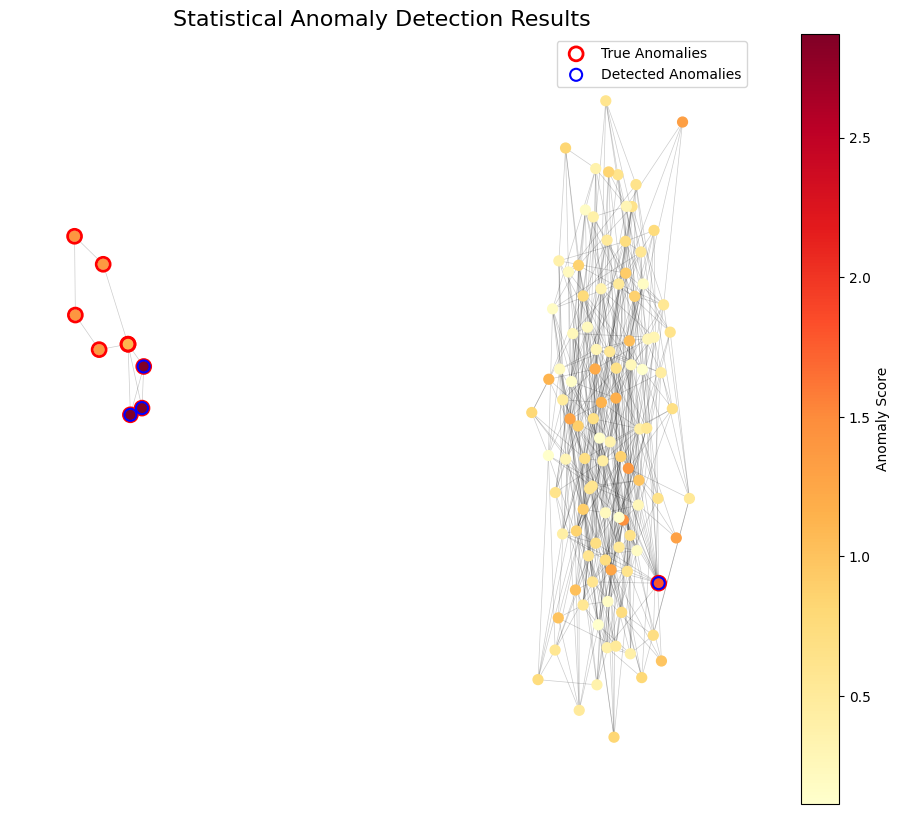

In [ ]:
# 3.1 Statistical Anomaly Detection

def statistical_anomaly_detection(G, metrics=['degree', 'clustering', 'betweenness'], threshold=2.5):
    """
    Detect anomalies based on statistical properties of nodes.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    metrics : list
        Metrics to consider
    threshold : float
        Z-score threshold for anomaly detection

    Returns:
    --------
    anomalies : dict
        Dictionary mapping metrics to lists of anomalous nodes
    scores : dict
        Dictionary mapping nodes to their anomaly scores
    """
    results = {}
    scores = {node: 0 for node in G.nodes()}

    # Calculate metrics
    if 'degree' in metrics:
        degrees = dict(G.degree())
        degree_values = list(degrees.values())
        deg_mean = np.mean(degree_values)
        deg_std = np.std(degree_values) if np.std(degree_values) > 0 else 1

        # Calculate z-scores
        degree_z = {node: abs((degrees[node] - deg_mean) / deg_std) for node in G.nodes()}
        degree_anomalies = [node for node, z in degree_z.items() if z > threshold]
        results['degree'] = degree_anomalies

        # Update scores
        for node in G.nodes():
            scores[node] += degree_z[node]

    if 'clustering' in metrics:
        clustering = nx.clustering(G)
        clustering_values = list(clustering.values())
        clust_mean = np.mean(clustering_values)
        clust_std = np.std(clustering_values) if np.std(clustering_values) > 0 else 1

        # Calculate z-scores
        clustering_z = {node: abs((clustering[node] - clust_mean) / clust_std) for node in G.nodes()}
        clustering_anomalies = [node for node, z in clustering_z.items() if z > threshold]
        results['clustering'] = clustering_anomalies

        # Update scores
        for node in G.nodes():
            scores[node] += clustering_z[node]

    if 'betweenness' in metrics:
        betweenness = nx.betweenness_centrality(G)
        betweenness_values = list(betweenness.values())
        bet_mean = np.mean(betweenness_values)
        bet_std = np.std(betweenness_values) if np.std(betweenness_values) > 0 else 1

        # Calculate z-scores
        betweenness_z = {node: abs((betweenness[node] - bet_mean) / bet_std) for node in G.nodes()}
        betweenness_anomalies = [node for node, z in betweenness_z.items() if z > threshold]
        results['betweenness'] = betweenness_anomalies

        # Update scores
        for node in G.nodes():
            scores[node] += betweenness_z[node]

    # Normalize scores by number of metrics
    for node in scores:
        scores[node] /= len(metrics)

    # Combined anomalies (anomalous in multiple metrics)
    all_anomalies = set()
    for metric_anomalies in results.values():
        all_anomalies.update(metric_anomalies)
    results['combined'] = list(all_anomalies)

    return results, scores

# Apply statistical anomaly detection to our financial network
stat_anomalies, stat_scores = statistical_anomaly_detection(G_financial)

# Evaluate detection accuracy
def evaluate_anomaly_detection(detected_nodes, true_anomalies):
    """Calculate precision, recall, and F1 score for anomaly detection"""
    true_positives = len(set(detected_nodes).intersection(set(true_anomalies)))
    precision = true_positives / len(detected_nodes) if len(detected_nodes) > 0 else 0
    recall = true_positives / len(true_anomalies) if len(true_anomalies) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precision, recall, f1

print("Statistical Method Results:")
print(f"True anomalies: {len(anomaly_nodes)}")
print(f"Detected anomalies: {len(stat_anomalies['combined'])}")
print(f"Detected by degree: {len(stat_anomalies['degree'])}")
print(f"Detected by clustering: {len(stat_anomalies['clustering'])}")
print(f"Detected by betweenness: {len(stat_anomalies['betweenness'])}")
print("\nPerformance:")
stat_performance = evaluate_anomaly_detection(stat_anomalies['combined'], anomaly_nodes)

# Visualize the results
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_financial, seed=42)

# Color nodes by anomaly score
node_colors = [stat_scores[node] for node in G_financial.nodes()]

# Draw nodes with color based on anomaly score
nodes = nx.draw_networkx_nodes(G_financial, pos, node_color=node_colors,
                               cmap='YlOrRd', node_size=50)
plt.colorbar(nodes, label='Anomaly Score')

# Mark true anomalies with red border
true_anomaly_nodes = nx.draw_networkx_nodes(G_financial, pos, nodelist=anomaly_nodes,
                                           node_color='none', node_size=100,
                                           edgecolors='red', linewidths=2)

# Draw detected anomalies with blue border
detected_nodes = nx.draw_networkx_nodes(G_financial, pos, nodelist=stat_anomalies['combined'],
                                       node_color='none', node_size=75,
                                       edgecolors='blue', linewidths=1.5)

# Draw edges
nx.draw_networkx_edges(G_financial, pos, alpha=0.2, width=0.5)

plt.title('Statistical Anomaly Detection Results', fontsize=16)
plt.legend([true_anomaly_nodes, detected_nodes], ['True Anomalies', 'Detected Anomalies'])
plt.axis('off')
plt.show()


### 3.2 Community-Based Anomaly Detection

Communities in graphs are groups of nodes that are densely connected internally but sparsely connected to other groups. Nodes that don't fit well into any community or connect multiple communities in unusual ways may be anomalous.


Detected 9 communities

Community-Based Method Results:
True anomalies: 10
Detected anomalies: 39

Performance:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


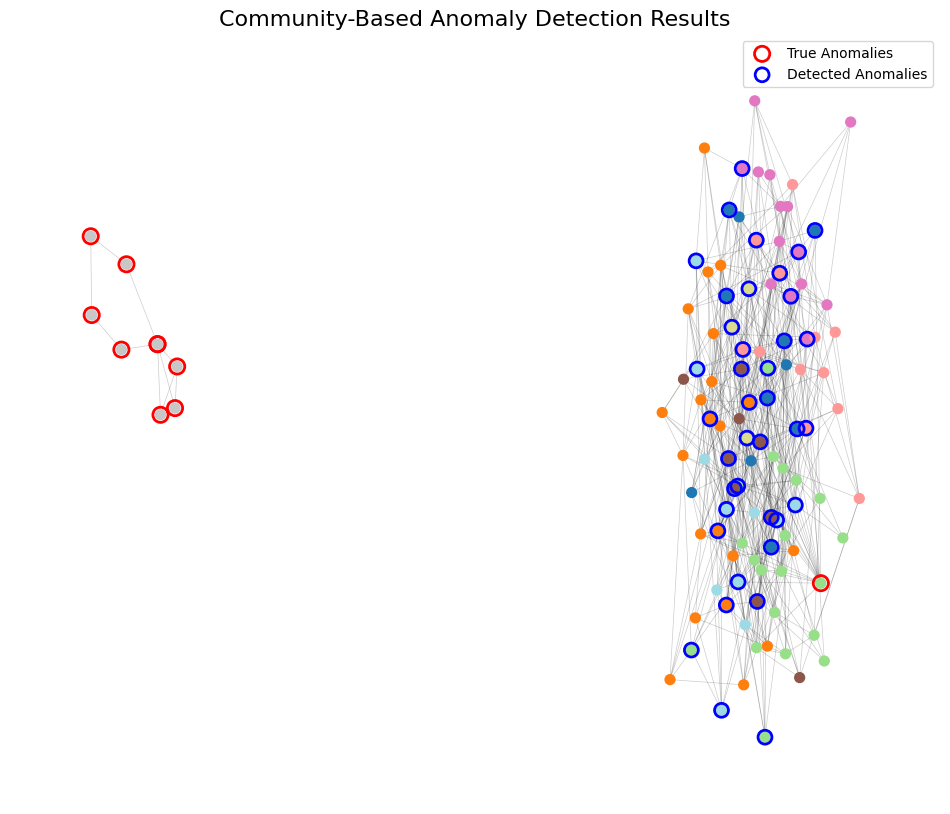

In [ ]:
# Community-based anomaly detection
def community_anomaly_detection(G, threshold=0.7):
    """
    Detect anomalies based on community structure.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    threshold : float
        Threshold for community membership strength

    Returns:
    --------
    anomalies : list
        List of anomalous nodes
    scores : dict
        Dictionary mapping nodes to their anomaly scores
    """
    # Detect communities using Louvain method
    try:
        import community as community_louvain
        communities = community_louvain.best_partition(G)
    except ImportError:
        # Fallback to networkx implementation
        communities = nx.community.louvain_communities(G)
        communities = {node: i for i, comm in enumerate(communities) for node in comm}

    # Count number of communities
    n_communities = len(set(communities.values()))
    print(f"Detected {n_communities} communities")

    # Create a dictionary mapping community ID to nodes in that community
    community_dict = {}
    for node, comm_id in communities.items():
        if comm_id not in community_dict:
            community_dict[comm_id] = []
        community_dict[comm_id].append(node)

    # For each node, calculate what fraction of its neighbors are in the same community
    scores = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 0:
            scores[node] = 0  # Isolated nodes are not anomalous by this measure
            continue

        # Count neighbors in same community
        node_comm = communities[node]
        same_comm_neighbors = sum(1 for neighbor in neighbors if communities[neighbor] == node_comm)
        comm_ratio = same_comm_neighbors / len(neighbors)

        # Anomaly score = 1 - community ratio (higher means more anomalous)
        scores[node] = 1 - comm_ratio

    # Nodes with high anomaly scores are anomalous
    anomalies = [node for node, score in scores.items() if score > threshold]

    return anomalies, scores, communities

# Apply community-based anomaly detection
comm_anomalies, comm_scores, communities = community_anomaly_detection(G_financial)

print("\nCommunity-Based Method Results:")
print(f"True anomalies: {len(anomaly_nodes)}")
print(f"Detected anomalies: {len(comm_anomalies)}")
print("\nPerformance:")
comm_performance = evaluate_anomaly_detection(comm_anomalies, anomaly_nodes)

# Visualize communities and anomalies
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_financial, seed=42)

# Color nodes by community
node_colors = [communities[node] for node in G_financial.nodes()]

# Draw nodes with color based on community
nodes = nx.draw_networkx_nodes(G_financial, pos, node_color=node_colors,
                              cmap='tab20', node_size=50)

# Draw edges
nx.draw_networkx_edges(G_financial, pos, alpha=0.2, width=0.5)

# Mark detected anomalies with blue border
detected_nodes = nx.draw_networkx_nodes(G_financial, pos, nodelist=comm_anomalies,
                                       node_color='none', node_size=100,
                                       edgecolors='blue', linewidths=2)

# Mark true anomalies with red border
true_anomaly_nodes = nx.draw_networkx_nodes(G_financial, pos, nodelist=anomaly_nodes,
                                           node_color='none', node_size=120,
                                           edgecolors='red', linewidths=2)

plt.title('Community-Based Anomaly Detection Results', fontsize=16)
plt.legend([true_anomaly_nodes, detected_nodes], ['True Anomalies', 'Detected Anomalies'])
plt.axis('off')
plt.show()


### 3.3 Spectral Anomaly Detection

Spectral methods leverage the eigenvalues and eigenvectors of graph matrices like the adjacency matrix or Laplacian. These capture global structural properties of the graph.

Nodes with unusual positions in the spectral embedding (eigenvectors corresponding to top eigenvalues) may be anomalous.



Spectral Method Results:
True anomalies: 10
Detected anomalies: 7

Performance:
Precision: 1.0000
Recall: 0.7000
F1 Score: 0.8235


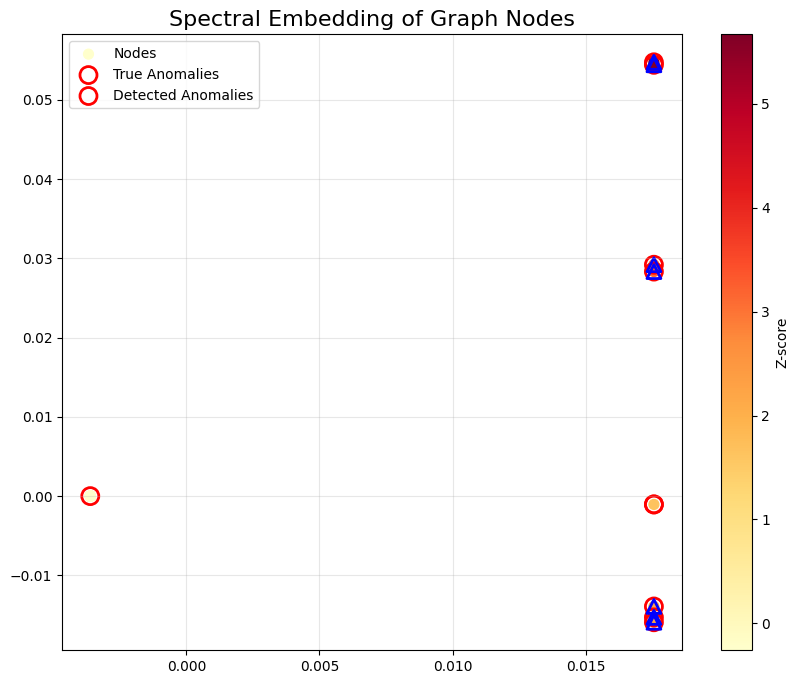

In [ ]:
# Spectral anomaly detection
def spectral_anomaly_detection(G, n_components=2, threshold=2):
    """
    Detect anomalies using spectral embedding.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    n_components : int
        Number of eigenvectors to use
    threshold : float
        Z-score threshold for considering points anomalous

    Returns:
    --------
    anomalies : list
        List of anomalous nodes
    embedding : ndarray
        Spectral embedding of nodes
    """
    # Compute adjacency matrix
    A = nx.to_numpy_array(G)

    # Get spectral embedding (top eigenvectors)
    from sklearn.manifold import SpectralEmbedding
    embedding = SpectralEmbedding(n_components=n_components,
                                 affinity='precomputed').fit_transform(A)

    # Calculate the distance of each point from the center
    center = np.mean(embedding, axis=0)
    distances = np.sqrt(np.sum((embedding - center)**2, axis=1))

    # Z-score normalization of distances
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    z_scores = (distances - mean_dist) / std_dist

    # Nodes with high z-scores are anomalous
    anomalies = [i for i, z in enumerate(z_scores) if z > threshold]

    return anomalies, embedding, z_scores

# Apply spectral anomaly detection
spec_anomalies, spec_embedding, spec_scores = spectral_anomaly_detection(G_financial)

print("\nSpectral Method Results:")
print(f"True anomalies: {len(anomaly_nodes)}")
print(f"Detected anomalies: {len(spec_anomalies)}")
print("\nPerformance:")
spec_performance = evaluate_anomaly_detection(spec_anomalies, anomaly_nodes)

# Visualize spectral embedding
plt.figure(figsize=(10, 8))

# Plot points colored by anomaly score
sc = plt.scatter(spec_embedding[:, 0], spec_embedding[:, 1],
                c=spec_scores, cmap='YlOrRd', s=50)
plt.colorbar(sc, label='Z-score')

# Mark true anomalies with red circles
for node in anomaly_nodes:
    plt.scatter(spec_embedding[node, 0], spec_embedding[node, 1],
               s=150, facecolors='none', edgecolors='red', linewidths=2)

# Mark detected anomalies with blue triangles
for node in spec_anomalies:
    plt.scatter(spec_embedding[node, 0], spec_embedding[node, 1],
               marker='^', s=100, facecolors='none', edgecolors='blue', linewidths=2)

plt.title('Spectral Embedding of Graph Nodes', fontsize=16)
plt.legend(['Nodes', 'True Anomalies', 'Detected Anomalies'])
plt.grid(True, alpha=0.3)
plt.show()


## 4. Graph Embeddings for Anomaly Detection

Graph embedding methods map nodes to a continuous low-dimensional vector space, preserving graph topology. This allows us to apply traditional machine learning methods like clustering or outlier detection to the embeddings.

### 4.1 Random Walk-Based Embeddings

These methods generate random walks on the graph, treat walks as "sentences," and use NLP techniques like Skip-gram to learn node representations.

Key approaches include:
- **DeepWalk**: Uses uniform random walks
- **Node2Vec**: Uses biased random walks with parameters p (return) and q (in-out) to control walk strategy


In [ ]:
# First we need to install node2vec if not already installed
#!pip install node2vec

from node2vec import Node2Vec

def node2vec_embedding(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=1):
    """
    Generate Node2Vec embeddings for graph nodes.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    dimensions : int
        Size of embeddings
    walk_length : int
        Length of each random walk
    num_walks : int
        Number of walks per node
    p : float
        Return parameter (controls likelihood of returning to previous node)
    q : float
        In-out parameter (controls DFS vs. BFS behavior)

    Returns:
    --------
    embeddings : dict
        Dictionary mapping node IDs to embedding vectors
    model : node2vec.Word2Vec
        Trained embedding model
    """
    # Precompute probabilities and generate walks
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length,
                       num_walks=num_walks, p=p, q=q, workers=4)

    # Train embeddings model
    model = node2vec.fit(window=10, min_count=1)

    # Extract node embeddings
    embeddings = {}
    for node in G.nodes():
        embeddings[node] = model.wv[str(node)]

    return embeddings, model

# Anomaly detection using embeddings
def embedding_anomaly_detection(embeddings, method='isolation_forest', contamination=0.1):
    """
    Detect anomalies in embeddings using outlier detection algorithms.

    Parameters:
    -----------
    embeddings : dict
        Node embeddings
    method : str
        Detection method ('isolation_forest', 'lof', or 'ocsvm')
    contamination : float
        Expected proportion of outliers

    Returns:
    --------
    anomalies : list
        List of anomalous nodes
    scores : array
        Anomaly scores
    """
    # Convert embeddings to array
    nodes = list(embeddings.keys())
    X = np.array([embeddings[node] for node in nodes])

    # Apply outlier detection method
    if method == 'isolation_forest':
        from sklearn.ensemble import IsolationForest
        detector = IsolationForest(contamination=contamination, random_state=42)
    elif method == 'lof':
        from sklearn.neighbors import LocalOutlierFactor
        detector = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    elif method == 'ocsvm':
        from sklearn.svm import OneClassSVM
        detector = OneClassSVM(nu=contamination)

    # Fit and predict
    if method == 'lof':
        y_pred = detector.fit_predict(X)
        # LOF scores need to be negated and accessed differently
        scores = -detector.negative_outlier_factor_
    else:
        detector.fit(X)
        y_pred = detector.predict(X)
        scores = detector.decision_function(X)

    # Get anomalies (labeled as -1)
    anomalies = [nodes[i] for i, label in enumerate(y_pred) if label == -1]

    return anomalies, scores

# Create Node2Vec embeddings with different parameters to see their effect
embeddings_configs = [
    {'p': 1, 'q': 1, 'name': 'Balanced'},  # Balanced between BFS and DFS
    {'p': 0.5, 'q': 2, 'name': 'Structural'}, # Favor structural equivalence
    {'p': 2, 'q': 0.5, 'name': 'Homophily'}  # Favor homophily
]

# Dict to store results
embedding_results = {}

for config in embeddings_configs:
    print(f"Generating {config['name']} embeddings (p={config['p']}, q={config['q']})...")
    embeddings, model = node2vec_embedding(G_financial, p=config['p'], q=config['q'], dimensions=32)

    # Detect anomalies
    anomalies, scores = embedding_anomaly_detection(embeddings)

    print(f"Detected {len(anomalies)} anomalies")
    print("Performance:")
    performance = evaluate_anomaly_detection(anomalies, anomaly_nodes)

    # Store results
    embedding_results[config['name']] = {
        'embeddings': embeddings,
        'anomalies': anomalies,
        'scores': scores,
        'performance': performance
    }


Generating Balanced embeddings (p=1, q=1)...


Computing transition probabilities:   0%|          | 0/109 [00:00<?, ?it/s]

Detected 11 anomalies
Performance:
Precision: 0.7273
Recall: 0.8000
F1 Score: 0.7619
Generating Structural embeddings (p=0.5, q=2)...


Computing transition probabilities:   0%|          | 0/109 [00:00<?, ?it/s]

Detected 11 anomalies
Performance:
Precision: 0.7273
Recall: 0.8000
F1 Score: 0.7619
Generating Homophily embeddings (p=2, q=0.5)...


Computing transition probabilities:   0%|          | 0/109 [00:00<?, ?it/s]

Detected 11 anomalies
Performance:
Precision: 0.7273
Recall: 0.8000
F1 Score: 0.7619


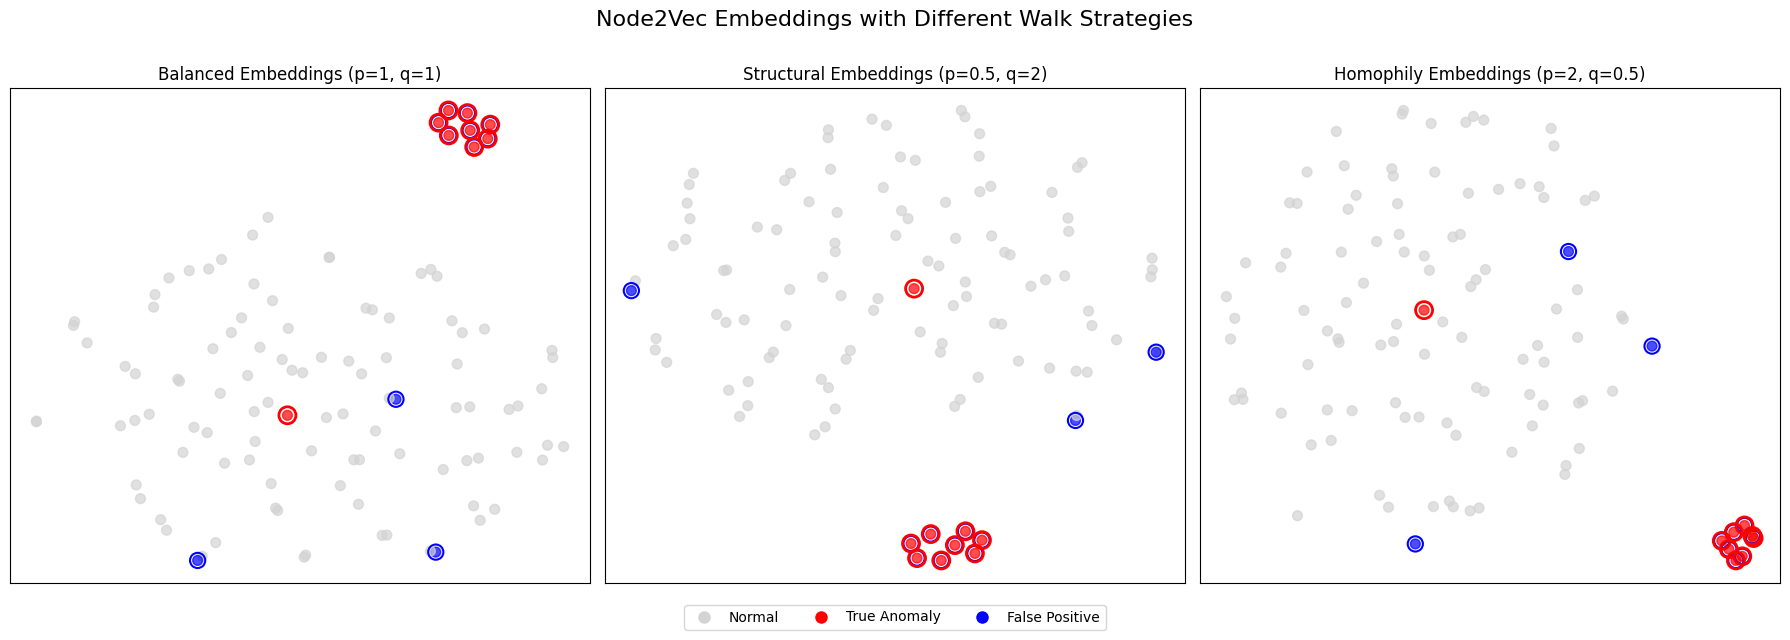

In [ ]:
# Visualize the embeddings using t-SNE
from sklearn.manifold import TSNE

# Prepare figure for embedding visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, config in enumerate(embeddings_configs):
    name = config['name']
    result = embedding_results[name]
    embeddings = result['embeddings']

    # Convert embeddings to array for t-SNE
    nodes = list(embeddings.keys())
    X = np.array([embeddings[node] for node in nodes])

    # Apply t-SNE for visualization
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

    # Define node colors: true anomalies in red, detected in blue
    node_colors = ['lightgray'] * len(nodes)
    for j, node in enumerate(nodes):
        if node in anomaly_nodes:
            node_colors[j] = 'red'
        elif node in result['anomalies'] and node not in anomaly_nodes:
            node_colors[j] = 'blue'

    # Plot embeddings
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=node_colors, s=50, alpha=0.7)

    # Highlight detected anomalies with blue circles
    for j, node in enumerate(nodes):
        if node in result['anomalies']:
            axes[i].scatter(X_tsne[j, 0], X_tsne[j, 1],
                          s=120, facecolors='none', edgecolors='blue', linewidths=1.5)

    # Highlight true anomalies with red circles
    for j, node in enumerate(nodes):
        if node in anomaly_nodes:
            axes[i].scatter(X_tsne[j, 0], X_tsne[j, 1],
                          s=150, facecolors='none', edgecolors='red', linewidths=2)

    axes[i].set_title(f"{name} Embeddings (p={config['p']}, q={config['q']})")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Create custom legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
]
fig.legend(custom_lines, ['Normal', 'True Anomaly', 'False Positive'],
           loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle('Node2Vec Embeddings with Different Walk Strategies', fontsize=16)
plt.show()


### 4.2 Skip-gram Model for Graph Embeddings

The Skip-gram model is a neural network architecture used to learn distributed representations of nodes in a graph. It works by maximizing the probability of observing context nodes given a center node.

For graph embeddings, we:
1. Generate random walks on the graph
2. For each node in a walk, predict its context nodes
3. Learn node embeddings that maximize this prediction accuracy

This is analogous to how word2vec works in natural language processing, but with graph walks instead of sentences.


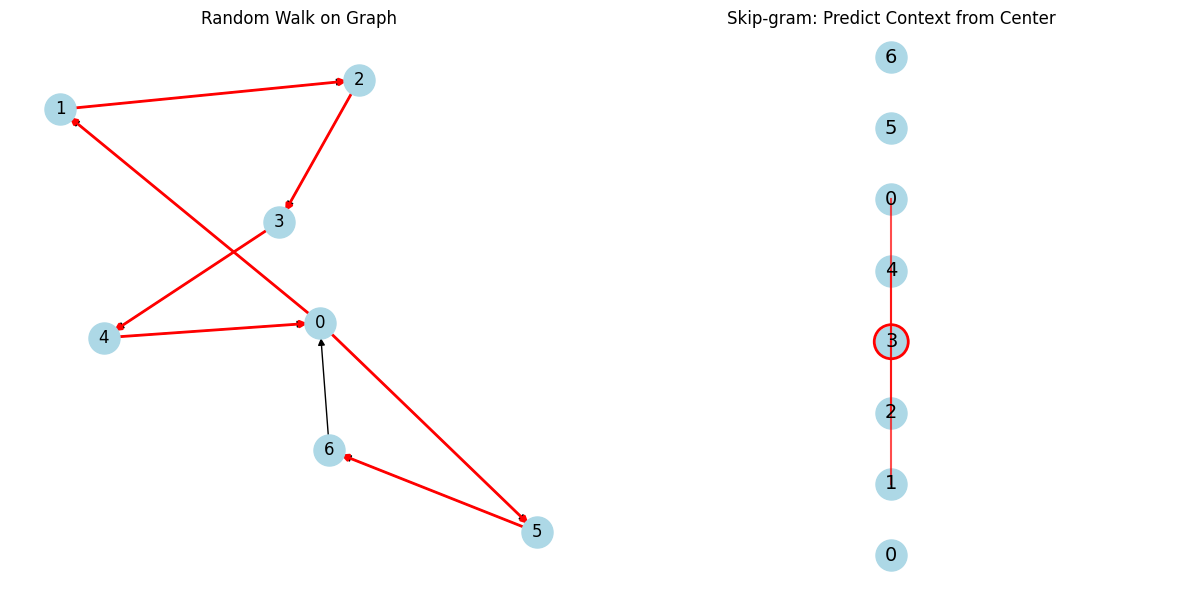

Example Skip-gram training pairs (center → context):
Node 0 → Context [1, 2]
Node 1 → Context [0, 2, 3]
Node 2 → Context [0, 1, 3, 4]
Node 3 → Context [1, 2, 4, 0]
Node 4 → Context [2, 3, 0, 5]
Node 0 → Context [3, 4, 5, 6]
Node 5 → Context [4, 0, 6]
Node 6 → Context [0, 5]


In [ ]:
# Let's examine how node2vec internals work with Skip-gram

def visualize_skipgram_concept():
    """
    Visualize how Skip-gram works for graph embeddings
    """
    # Create a small graph for demonstration
    G_small = nx.DiGraph()
    G_small.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0),
                           (0, 5), (5, 6), (6, 0)])

    # Generate a random walk
    walk = [0, 1, 2, 3, 4, 0, 5, 6]

    # Example window size
    window_size = 2

    # Visualize the graph
    plt.figure(figsize=(12, 6))

    # Plot graph on the left
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G_small, seed=42)
    nx.draw(G_small, pos, with_labels=True, node_color='lightblue',
           node_size=500, arrows=True)

    # Highlight the walk
    walk_edges = [(walk[i], walk[i+1]) for i in range(len(walk)-1)]
    nx.draw_networkx_edges(G_small, pos, edgelist=walk_edges, edge_color='red',
                          width=2)

    plt.title('Random Walk on Graph')

    # Plot Skip-gram concept on the right
    plt.subplot(1, 2, 2)

    # Set up coordinates
    y_positions = [0, 1, 2, 3, 4, 5, 6, 7]
    x_positions = [2] * len(y_positions)

    # Plot nodes
    plt.scatter(x_positions, y_positions, s=500, c='lightblue')

    # Add node labels
    for i, node in enumerate(walk):
        plt.text(x_positions[i], y_positions[i], str(node),
                ha='center', va='center', fontsize=14)

    # Mark center node and context for an example
    center_idx = 3  # Node 3 in the walk
    plt.scatter([x_positions[center_idx]], [y_positions[center_idx]],
               s=600, facecolors='none', edgecolors='red', linewidths=2)

    # Connect to context nodes
    for j in range(max(0, center_idx-window_size), min(len(walk), center_idx+window_size+1)):
        if j != center_idx:
            plt.plot([x_positions[center_idx], x_positions[j]],
                    [y_positions[center_idx], y_positions[j]],
                    'r-', alpha=0.7)

    plt.title('Skip-gram: Predict Context from Center')
    plt.xlim(0, 4)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Show example training pairs
    print("Example Skip-gram training pairs (center → context):")
    for i in range(len(walk)):
        center = walk[i]
        context = []
        for j in range(max(0, i-window_size), min(len(walk), i+window_size+1)):
            if j != i:
                context.append(walk[j])
        print(f"Node {center} → Context {context}")

# Visualize Skip-gram concept
visualize_skipgram_concept()


## 5. Graph Neural Networks for Anomaly Detection

Graph Neural Networks (GNNs) are deep learning models designed to capture the structure and attributes of graph data. Unlike graph embeddings which are fixed after training, GNNs can generalize to unseen nodes and graphs.

### 5.1 GNN Fundamentals

The key idea behind GNNs is **message passing**:
1. Nodes aggregate information from their neighbors
2. Node representations are updated based on this aggregated information
3. After multiple layers, each node's representation captures its neighborhood structure

Graph Convolutional Networks (GCNs) are a popular type of GNN that generalize convolution operations to graph data.


In [ ]:
# We need PyTorch and PyTorch Geometric for GNN implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### 5.2 Setting Up Graph Data for GNNs

To use graph data with GNNs, we need to convert our NetworkX graph to PyTorch Geometric's `Data` format, which includes:
- Node features
- Edge indices (COO format)
- Edge attributes (optional)
- Labels (for supervised learning)

Let's prepare our financial transaction network for GNN processing:


In [ ]:
# Create node features and edge index for PyTorch Geometric
def prepare_pyg_data(G, anomaly_nodes=None):
    """
    Convert NetworkX graph to PyTorch Geometric Data object.

    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    anomaly_nodes : list
        List of known anomalous nodes for labels

    Returns:
    --------
    data : torch_geometric.data.Data
        PyTorch Geometric Data object
    """
    # Extract node features
    features = []
    for node in sorted(G.nodes()):
        if 'features' in G.nodes[node]:
            features.append(G.nodes[node]['features'])
        else:
            # If no features are available, use one-hot encoding of node ID
            one_hot = np.zeros(G.number_of_nodes())
            one_hot[node] = 1.0
            features.append(one_hot)

    x = torch.tensor(np.array(features), dtype=torch.float)

    # Create edge index (COO format)
    edge_index = []
    edge_attr = []
    for u, v, data in G.edges(data=True):
        # Each edge appears twice in undirected graph, indicating both directions
        edge_index.append([u, v])
        edge_index.append([v, u])  # For undirected graph

        # Add edge attributes if available
        if 'weight' in data:
            edge_attr.append([data['weight']])
            edge_attr.append([data['weight']])  # Same weight for both directions

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    if edge_attr:
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_attr = None

    # Create labels (1 for anomaly, 0 for normal)
    if anomaly_nodes:
        y = torch.zeros(G.number_of_nodes(), dtype=torch.long)
        for node in anomaly_nodes:
            if node < G.number_of_nodes():
                y[node] = 1
    else:
        y = None

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    return data

# Prepare financial network data
pyg_data = prepare_pyg_data(G_financial, anomaly_nodes)
print(pyg_data)

# Check data shape
print(f"Number of nodes: {pyg_data.num_nodes}")
print(f"Number of edges: {pyg_data.num_edges}")
print(f"Number of node features: {pyg_data.num_node_features}")
print(f"Number of anomalies: {pyg_data.y.sum().item()}")


Data(x=[109, 8], edge_index=[2, 1002], edge_attr=[1002, 1], y=[109])
Number of nodes: 109
Number of edges: 1002
Number of node features: 8
Number of anomalies: 9


### 5.3 Graph Convolutional Networks (GCNs)

The Graph Convolutional Network is formulated as:

$$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$$

Where:
- $\tilde{A} = A + I$ is the adjacency matrix with added self-loops
- $\tilde{D}$ is the degree matrix of $\tilde{A}$
- $H^{(l)}$ is the node feature matrix at layer $l$
- $W^{(l)}$ is the learnable weight matrix
- $\sigma$ is an activation function like ReLU

Let's implement a basic GCN model for graph anomaly detection.


Epoch 10/100, Loss: 0.2263
Epoch 20/100, Loss: 0.1851
Epoch 30/100, Loss: 0.1587
Epoch 40/100, Loss: 0.1369
Epoch 50/100, Loss: 0.0967
Epoch 60/100, Loss: 0.0689
Epoch 70/100, Loss: 0.0537
Epoch 80/100, Loss: 0.0709
Epoch 90/100, Loss: 0.0369
Epoch 100/100, Loss: 0.0517


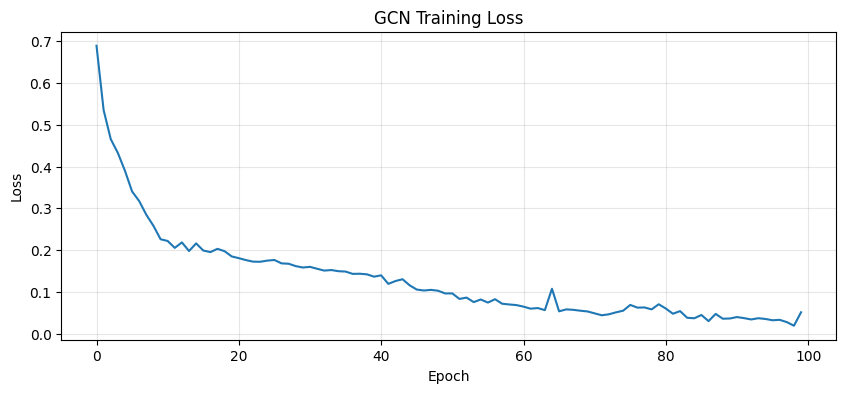

Accuracy: 0.9908
Precision: 0.9000
Recall: 1.0000
F1 Score: 0.9474


In [ ]:
class GCN(nn.Module):
    """
    Graph Convolutional Network for anomaly detection.
    """
    def __init__(self, in_features, hidden_dim, out_features):
        """
        Initialize GCN model.

        Parameters:
        -----------
        in_features : int
            Number of input features
        hidden_dim : int
            Dimension of hidden layers
        out_features : int
            Number of output features/classes
        """
        super(GCN, self).__init__()

        # First GCN layer
        self.conv1 = GCNConv(in_features, hidden_dim)

        # Second GCN layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)

        # Output layer
        self.linear = nn.Linear(hidden_dim // 2, out_features)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        """
        Forward pass.

        Parameters:
        -----------
        x : torch.Tensor
            Node feature matrix
        edge_index : torch.Tensor
            Graph connectivity in COO format

        Returns:
        --------
        torch.Tensor
            Output predictions
        """
        # First layer
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.dropout(h)

        # Second layer
        h = self.conv2(h, edge_index)
        h = F.relu(h)

        # Output layer
        out = self.linear(h)

        return out

    def get_embeddings(self, x, edge_index):
        """
        Get node embeddings from the model.

        Parameters:
        -----------
        x : torch.Tensor
            Node feature matrix
        edge_index : torch.Tensor
            Graph connectivity in COO format

        Returns:
        --------
        torch.Tensor
            Node embeddings
        """
        # First layer
        h = self.conv1(x, edge_index)
        h = F.relu(h)

        # Second layer
        h = self.conv2(h, edge_index)
        h = F.relu(h)

        return h

# Train a GCN model for anomaly detection
def train_eval_gcn(data, hidden_dim=64, epochs=200, lr=0.01):
    """
    Train and evaluate a GCN model for anomaly detection.

    Parameters:
    -----------
    data : torch_geometric.data.Data
        Input data
    hidden_dim : int
        Hidden dimension size
    epochs : int
        Number of training epochs
    lr : float
        Learning rate

    Returns:
    --------
    model : GCN
        Trained GCN model
    """
    # Create model
    model = GCN(in_features=data.num_node_features,
               hidden_dim=hidden_dim,
               out_features=2).to(device)  # 2 classes: normal and anomaly

    # Move data to device
    data = data.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    # Define loss function with class weighting due to imbalance
    num_anomalies = data.y.sum().item()
    num_normal = len(data.y) - num_anomalies
    weight = torch.tensor([1.0/num_normal, 1.0/num_anomalies]).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight)

    # Training loop
    model.train()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    # Plot training curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('GCN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Calculate metrics
        correct = (pred == data.y).sum().item()
        accuracy = correct / len(data.y)

        # For anomaly detection specifically
        true_positives = ((pred == 1) & (data.y == 1)).sum().item()
        false_positives = ((pred == 1) & (data.y == 0)).sum().item()
        false_negatives = ((pred == 0) & (data.y == 1)).sum().item()

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return model

# Train GCN model
gcn_model = train_eval_gcn(pyg_data, hidden_dim=64, epochs=100)

# Get embeddings
with torch.no_grad():
    node_embeddings = gcn_model.get_embeddings(pyg_data.x, pyg_data.edge_index).cpu().numpy()


### 5.4 Visualizing GCN Embeddings

Let's visualize the node embeddings learned by our GCN model to see how well it separates normal and anomalous nodes.


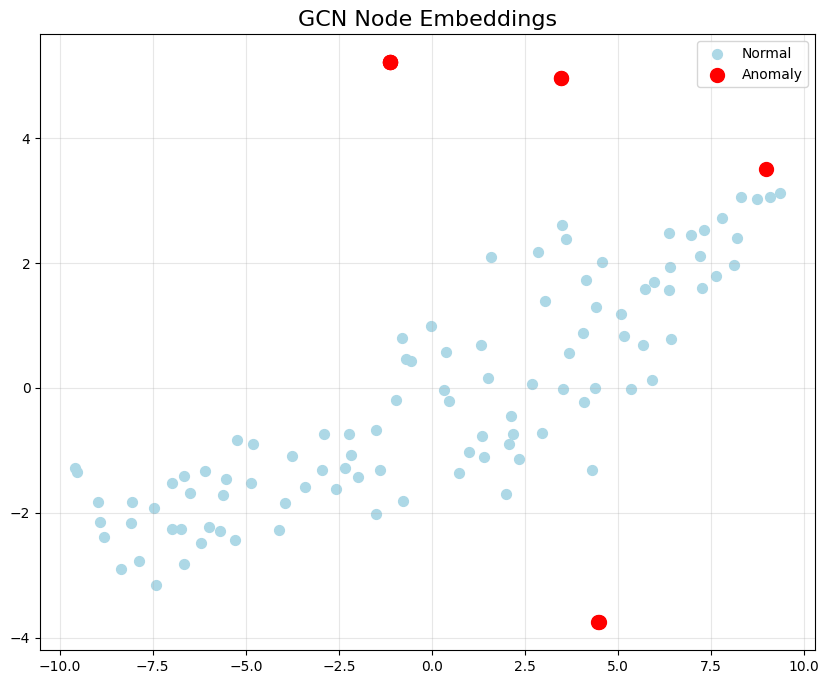

In [ ]:
# Visualize GCN embeddings
def visualize_embeddings(embeddings, labels, title):
    """
    Visualize embeddings using t-SNE.

    Parameters:
    -----------
    embeddings : ndarray
        Node embeddings
    labels : ndarray
        Node labels (0 for normal, 1 for anomaly)
    title : str
        Plot title
    """
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))

    # Plot normal nodes
    normal_mask = (labels == 0)
    plt.scatter(embeddings_2d[normal_mask, 0], embeddings_2d[normal_mask, 1],
               c='lightblue', s=50, label='Normal')

    # Plot anomalous nodes
    anomaly_mask = (labels == 1)
    plt.scatter(embeddings_2d[anomaly_mask, 0], embeddings_2d[anomaly_mask, 1],
               c='red', s=100, label='Anomaly')

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Get node labels
labels = pyg_data.y.cpu().numpy()

# Visualize GCN embeddings
visualize_embeddings(node_embeddings, labels, 'GCN Node Embeddings')


## 6. GCN Autoencoders for Anomaly Detection

Autoencoders are unsupervised learning models that learn to reconstruct their input data. When applied to graphs using GCNs, they can learn normal graph patterns and identify anomalies as instances that are difficult to reconstruct.

### 6.1 Basic GCN Autoencoder

A GCN autoencoder consists of:
- An encoder that compresses node features and graph structure into a latent space
- A decoder that reconstructs the original graph from the latent representation

For anomaly detection, we train on normal data and detect nodes with high reconstruction error.


Epoch 10/100, Loss: 0.807507
Epoch 20/100, Loss: 0.736350
Epoch 30/100, Loss: 0.682900
Epoch 40/100, Loss: 0.619716
Epoch 50/100, Loss: 0.571795
Epoch 60/100, Loss: 0.540665
Epoch 70/100, Loss: 0.514516
Epoch 80/100, Loss: 0.494008
Epoch 90/100, Loss: 0.478662
Epoch 100/100, Loss: 0.464358


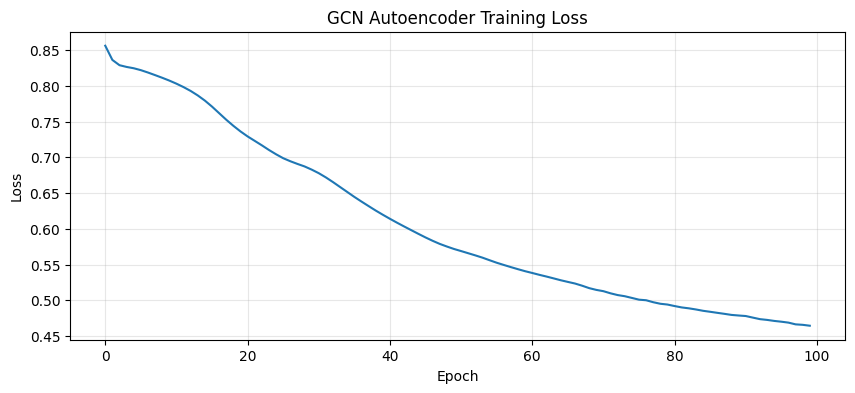

In [ ]:
class GCNAutoencoder(nn.Module):
    """
    Graph Convolutional Network Autoencoder for unsupervised anomaly detection.
    """
    def __init__(self, in_features, hidden_dim, latent_dim):
        """
        Initialize GCN Autoencoder.

        Parameters:
        -----------
        in_features : int
            Number of input features
        hidden_dim : int
            Dimension of hidden layers
        latent_dim : int
            Dimension of latent space
        """
        super(GCNAutoencoder, self).__init__()

        # Encoder
        self.encoder_conv1 = GCNConv(in_features, hidden_dim)
        self.encoder_conv2 = GCNConv(hidden_dim, latent_dim)

        # Decoder for feature reconstruction
        self.decoder_linear1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_linear2 = nn.Linear(hidden_dim, in_features)

    def encode(self, x, edge_index):
        """
        Encode node features into latent space.

        Parameters:
        -----------
        x : torch.Tensor
            Node feature matrix
        edge_index : torch.Tensor
            Graph connectivity in COO format

        Returns:
        --------
        torch.Tensor
            Latent representations
        """
        h = self.encoder_conv1(x, edge_index)
        h = F.relu(h)
        h = self.encoder_conv2(h, edge_index)
        return h

    def decode(self, z):
        """
        Decode latent representations to reconstruct node features.

        Parameters:
        -----------
        z : torch.Tensor
            Latent representations

        Returns:
        --------
        torch.Tensor
            Reconstructed node features
        """
        h = self.decoder_linear1(z)
        h = F.relu(h)
        return self.decoder_linear2(h)

    def decode_structure(self, z):
        """
        Decode latent representations to reconstruct adjacency matrix.

        Parameters:
        -----------
        z : torch.Tensor
            Latent representations

        Returns:
        --------
        torch.Tensor
            Reconstructed adjacency matrix
        """
        # Inner product decoder: A' = σ(ZZ^T)
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

    def forward(self, x, edge_index):
        """
        Forward pass.

        Parameters:
        -----------
        x : torch.Tensor
            Node feature matrix
        edge_index : torch.Tensor
            Graph connectivity in COO format

        Returns:
        --------
        tuple
            (encoded, reconstructed_features, reconstructed_adjacency)
        """
        # Encode
        z = self.encode(x, edge_index)

        # Decode features
        x_hat = self.decode(z)

        # Decode structure
        adj_hat = self.decode_structure(z)

        return z, x_hat, adj_hat

# Train the GCN Autoencoder
def train_gcn_autoencoder(data, hidden_dim=32, latent_dim=16, epochs=200, lr=0.01,
                         alpha=0.5, use_unsupervised=True):
    """
    Train a GCN Autoencoder for anomaly detection.

    Parameters:
    -----------
    data : torch_geometric.data.Data
        Input data
    hidden_dim : int
        Hidden dimension size
    latent_dim : int
        Latent dimension size
    epochs : int
        Number of training epochs
    lr : float
        Learning rate
    alpha : float
        Weight for structure vs. feature reconstruction
    use_unsupervised : bool
        If True, train only on normal nodes. If False, use all nodes.

    Returns:
    --------
    model : GCNAutoencoder
        Trained model
    """
    # Create model
    model = GCNAutoencoder(in_features=data.num_node_features,
                          hidden_dim=hidden_dim,
                          latent_dim=latent_dim).to(device)

    # Create adjacency matrix for reconstruction target
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    adj[edge_index[0], edge_index[1]] = 1

    # Move data to device
    data = data.to(device)

    # Select training nodes (only normal nodes if use_unsupervised=True)
    if use_unsupervised:
        train_mask = (data.y == 0)
    else:
        train_mask = torch.ones(data.num_nodes, dtype=torch.bool)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        z, x_hat, adj_hat = model(data.x, data.edge_index)

        # Feature reconstruction loss
        feat_loss = F.mse_loss(x_hat[train_mask], data.x[train_mask])

        # Structure reconstruction loss (only for connections involving training nodes)
        struct_loss = F.binary_cross_entropy(adj_hat[train_mask][:, train_mask],
                                           adj[train_mask][:, train_mask])

        # Combined loss
        loss = alpha * struct_loss + (1 - alpha) * feat_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

    # Plot training curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title('GCN Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

    return model

# Train GCN autoencoder
gcn_ae_model = train_gcn_autoencoder(pyg_data, hidden_dim=32, latent_dim=16,
                                    epochs=100, alpha=0.5, use_unsupervised=True)


### 6.2 Using GCN Autoencoder for Anomaly Detection

Now that we've trained our autoencoder, let's use it to detect anomalies by calculating reconstruction errors.



GCN Autoencoder Results:
True anomalies: 10
Detected anomalies: 13

Performance:
Precision: 0.6154
Recall: 0.8000
F1 Score: 0.6957


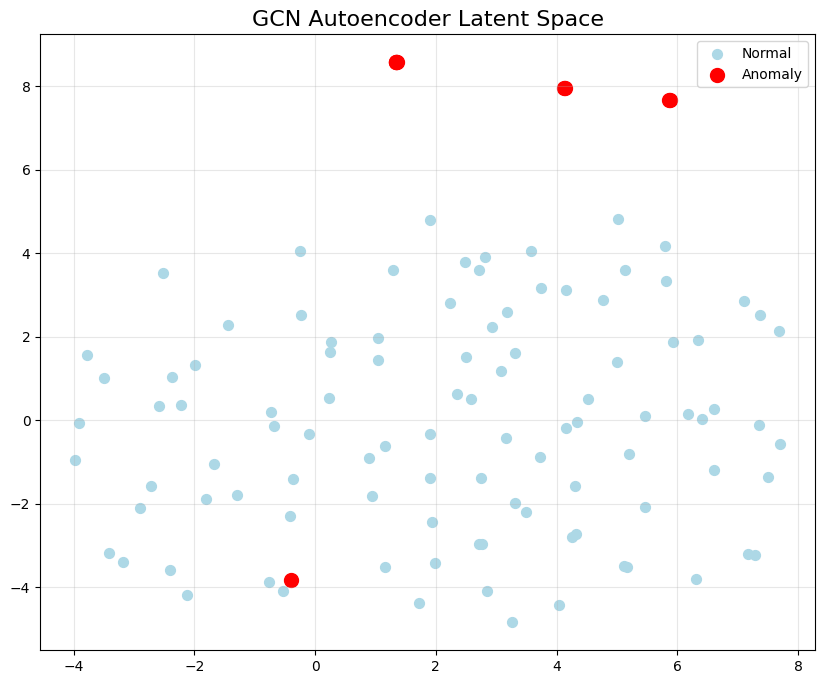

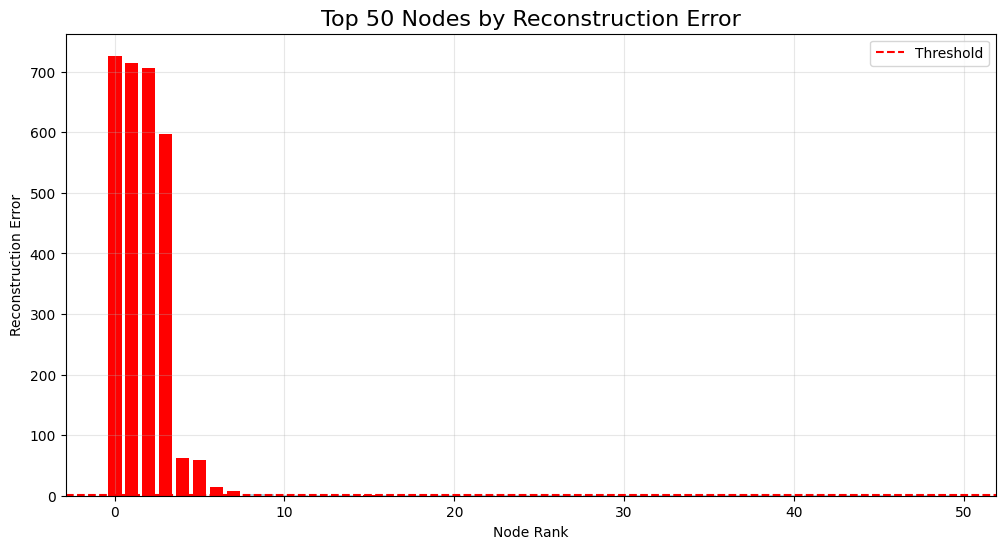

In [ ]:
# Calculate reconstruction errors for anomaly detection
def gcn_ae_anomaly_detection(model, data, alpha=0.5, threshold_percentile=95):
    """
    Detect anomalies using GCN autoencoder reconstruction errors.

    Parameters:
    -----------
    model : GCNAutoencoder
        Trained autoencoder model
    data : torch_geometric.data.Data
        Input data
    alpha : float
        Weight for structure vs. feature reconstruction error
    threshold_percentile : float
        Percentile for threshold calculation

    Returns:
    --------
    anomalies : list
        Detected anomalous nodes
    scores : array
        Anomaly scores for all nodes
    """
    model.eval()

    # Create adjacency matrix
    edge_index = data.edge_index.cpu().numpy()
    num_nodes = data.num_nodes
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    adj[edge_index[0], edge_index[1]] = 1

    # Forward pass
    with torch.no_grad():
        z, x_hat, adj_hat = model(data.x.to(device), data.edge_index.to(device))

        # Calculate feature reconstruction error per node
        feat_errors = F.mse_loss(x_hat, data.x.to(device), reduction='none')
        feat_errors = feat_errors.mean(dim=1).cpu().numpy()

        # Calculate structure reconstruction error per node
        struct_errors = F.binary_cross_entropy(adj_hat, adj, reduction='none')
        struct_errors = struct_errors.mean(dim=1).cpu().numpy()

        # Combined error
        errors = alpha * struct_errors + (1 - alpha) * feat_errors

        # Determine threshold from normal nodes
        normal_mask = (data.y.cpu().numpy() == 0)
        normal_errors = errors[normal_mask]
        threshold = np.percentile(normal_errors, threshold_percentile)

        # Detect anomalies
        anomalies = np.where(errors > threshold)[0]

    return anomalies, errors, threshold

# Detect anomalies using GCN autoencoder
ae_anomalies, ae_scores, ae_threshold = gcn_ae_anomaly_detection(gcn_ae_model, pyg_data)

# Evaluate results
print("\nGCN Autoencoder Results:")
print(f"True anomalies: {len(anomaly_nodes)}")
print(f"Detected anomalies: {len(ae_anomalies)}")
print("\nPerformance:")
ae_performance = evaluate_anomaly_detection(ae_anomalies, anomaly_nodes)

# Visualize autoencoder latent space
with torch.no_grad():
    z, _, _ = gcn_ae_model(pyg_data.x.to(device), pyg_data.edge_index.to(device))
    latent_space = z.cpu().numpy()

# Visualize latent embeddings
visualize_embeddings(latent_space, pyg_data.y.cpu().numpy(), 'GCN Autoencoder Latent Space')

# Visualize reconstruction errors
plt.figure(figsize=(12, 6))

# Sort nodes by error score
sorted_indices = np.argsort(ae_scores)[::-1]  # Descending order
sorted_scores = ae_scores[sorted_indices]
sorted_labels = pyg_data.y.cpu().numpy()[sorted_indices]

# Bar colors
colors = ['red' if label == 1 else 'lightblue' for label in sorted_labels]

# Plot top 50 nodes by error
plt.bar(range(50), sorted_scores[:50], color=colors[:50])
plt.axhline(y=ae_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Top 50 Nodes by Reconstruction Error', fontsize=16)
plt.xlabel('Node Rank')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 7. Comparing Methods and Visualizing Results

Let's compile the results from all the methods we've implemented and visualize their performance.


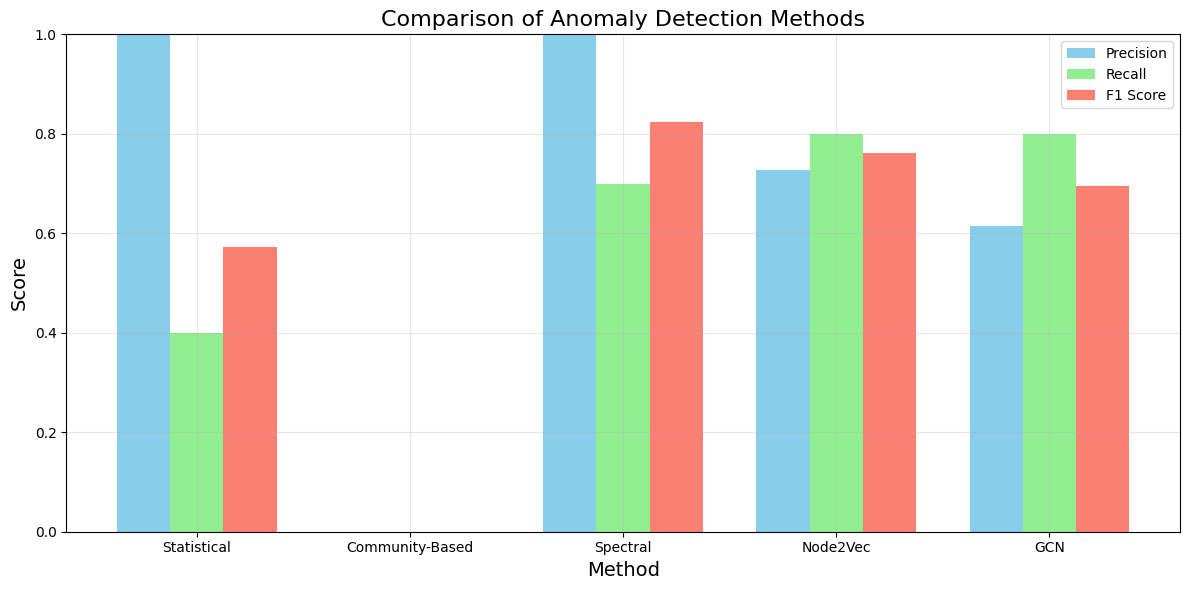

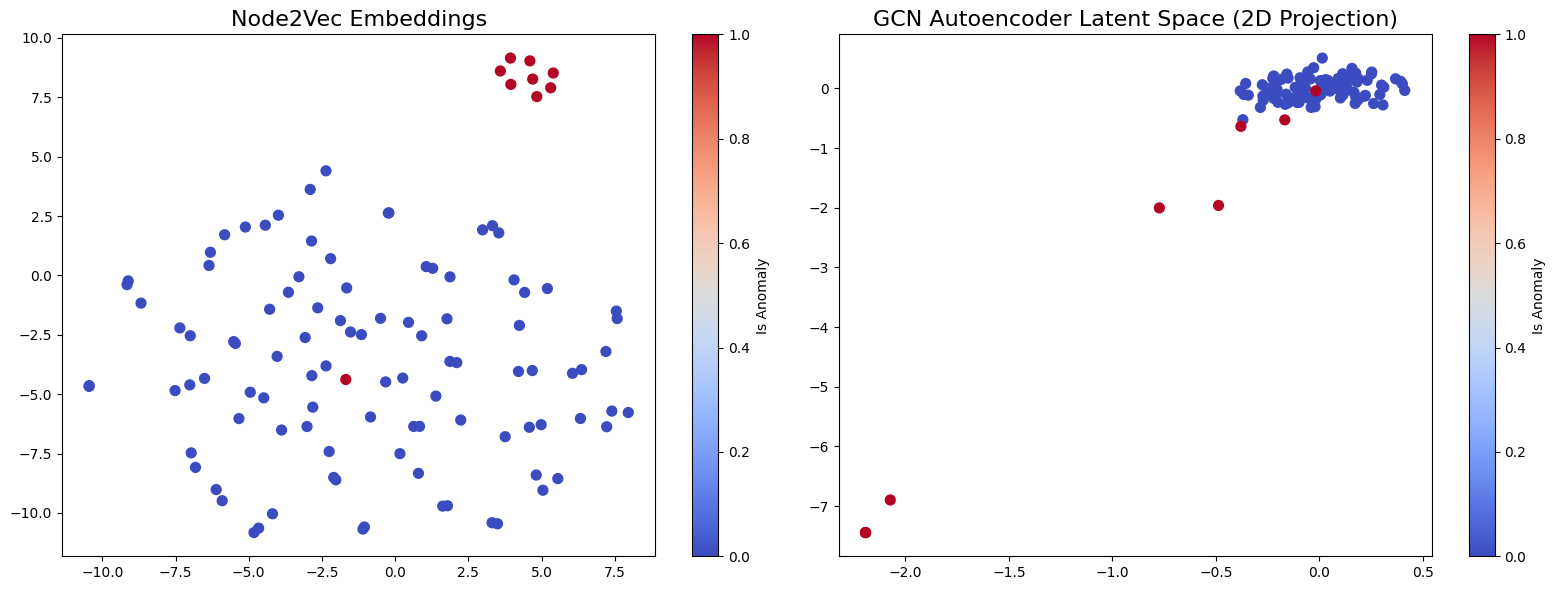

In [ ]:
# Compile results from all methods
methods = ['Statistical', 'Community-Based', 'Spectral', 'Node2Vec', 'GCN', 'GCN Autoencoder']

# Collect performance metrics
precisions = [
    stat_performance[0],
    comm_performance[0],
    spec_performance[0],
    embedding_results['Balanced']['performance'][0],
    ae_performance[0]  # GCN Autoencoder
]

recalls = [
    stat_performance[1],
    comm_performance[1],
    spec_performance[1],
    embedding_results['Balanced']['performance'][1],
    ae_performance[1]  # GCN Autoencoder
]

f1_scores = [
    stat_performance[2],
    comm_performance[2],
    spec_performance[2],
    embedding_results['Balanced']['performance'][2],
    ae_performance[2]  # GCN Autoencoder
]

# Create comparison plot
plt.figure(figsize=(12, 6))
x = np.arange(len(methods) - 1)  # Skip GCN supervised as it's not directly comparable
width = 0.25

plt.bar(x - width, precisions, width, label='Precision', color='skyblue')
plt.bar(x, recalls, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1_scores, width, label='F1 Score', color='salmon')

plt.xlabel('Method', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Comparison of Anomaly Detection Methods', fontsize=16)
plt.xticks(x, methods[:-1])
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize node2vec vs GCN autoencoder embeddings
plt.figure(figsize=(16, 6))

# Node2Vec embeddings
plt.subplot(1, 2, 1)
nodes = list(embedding_results['Balanced']['embeddings'].keys())
X = np.array([embedding_results['Balanced']['embeddings'][node] for node in nodes])
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
          c=[pyg_data.y[i].item() for i in range(len(nodes))],
          cmap='coolwarm', s=50)
plt.title('Node2Vec Embeddings', fontsize=16)
plt.colorbar(label='Is Anomaly')

# GCN Autoencoder embeddings
plt.subplot(1, 2, 2)
plt.scatter(latent_space[:, 0], latent_space[:, 1],
          c=pyg_data.y.cpu().numpy(), cmap='coolwarm', s=50)
plt.title('GCN Autoencoder Latent Space (2D Projection)', fontsize=16)
plt.colorbar(label='Is Anomaly')

plt.tight_layout()
plt.show()


## 8. Conclusion and Key Takeaways

In this notebook, we've explored a wide range of graph-based anomaly detection methods, from simple statistical approaches to advanced deep learning models.

### Key Points:

1. **Graph Structure Matters**: Anomalies in graphs often manifest as unusual connectivity patterns or structural properties that can't be detected by looking at nodes in isolation.

2. **Node Features Enhance Detection**: Combining structural information with node features can significantly improve anomaly detection, especially for complex patterns.

3. **Method Selection Depends on Context**:
   - **Statistical methods**: Fast and interpretable, good for simple anomalies
   - **Embedding methods**: Balance of efficiency and effectiveness
   - **GNN-based approaches**: Best for complex, subtle anomalies

4. **Advantages of Graph Neural Networks**:
   - Learn representations that capture both structure and features
   - Can generalize to unseen nodes and graphs
   - Detect complex anomaly patterns

5. **Unsupervised Learning is Powerful**: Autoencoder-based approaches can detect anomalies without labeled examples, making them particularly useful in real-world scenarios.

### Applications:

These techniques have applications across various domains:
- Financial fraud detection
- Network security and intrusion detection
- Social network analysis
- Biological network analysis
- Supply chain monitoring
- Infrastructure fault detection

### Future Directions:
- **Temporal graph neural networks** for evolving graphs
- **Self-supervised learning** approaches to better leverage unlabeled data
- **Explainable AI** methods to interpret anomaly detection results
